In [1]:
import tensorflow as tf
tf.keras.utils.get_file('cats_and_dogs_filtered.zip',"https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip")

2023-02-26 15:47:08.897552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 15:47:09.422685: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-26 15:47:09.458733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-26 15:47:09.458773: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

'/home/salman/.keras/datasets/cats_and_dogs_filtered.zip'

In [2]:
import os
import zipfile #to handle zip file

local_zip = '/home/salman/.keras/datasets/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

In [4]:
std_normalize = transforms.Normalize(mean=[0, 0, 0],std=[1, 1, 1])

In [5]:
trans_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize
])
trans_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder('cats_and_dogs_filtered/train',transform=trans_train)

In [7]:
test_dataset = torchvision.datasets.ImageFolder('cats_and_dogs_filtered/validation',transform=trans_test)

In [8]:
batch_size = 20

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [10]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)

In [11]:
examples = iter(train_loader)
samples ,labels = next(examples)
print(samples.shape)
labels


torch.Size([20, 3, 224, 224])


tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0])

In [12]:
def imshow(img,title):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(title)
    plt.show()

In [13]:
sample_plot = samples[0:16]
label_plot = labels[0:16]

In [14]:
out = torchvision.utils.make_grid(sample_plot)

In [15]:
class_name = train_dataset.classes

In [16]:
class_name

['cats', 'dogs']

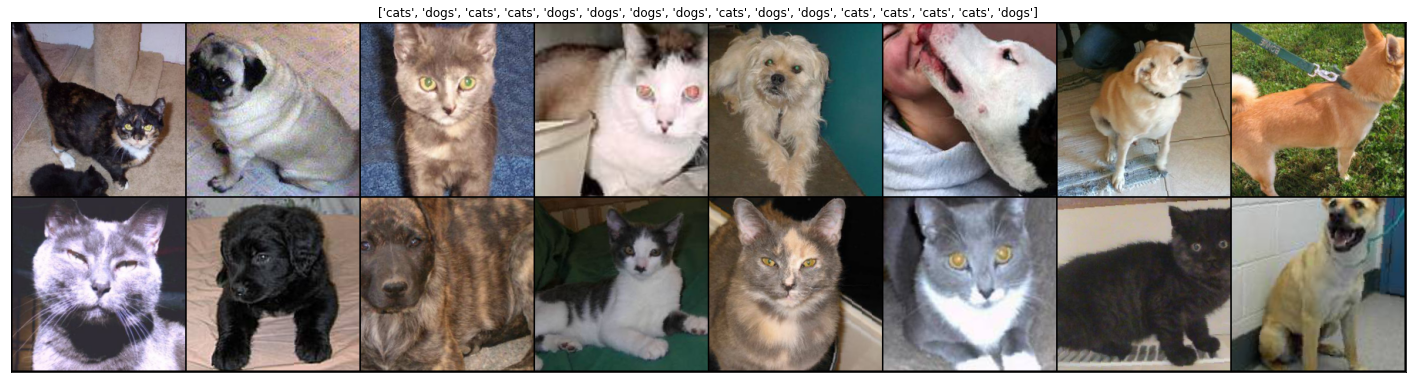

In [17]:
imshow(out,title=[class_name[x] for x in label_plot])

In [18]:
model = models.resnet50(pretrained=True)

/home/salman/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/salman/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
#Freeze all params
for params in model.parameters():
 params.requires_grad_ = False

In [20]:
#Add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Sequential(nn.Linear(nr_filters,512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512,2))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
model = model.to(device)

In [22]:
#Train the network
num_epochs = 2
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        #labels = labels.unsqueeze(1).float()
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if (epoch+1) % 1 == 0:    # 
        #    print(f'epoch:{epoch+1},loss={running_loss}')
        #    running_loss = 0.0
        if not i % 8:
            print (f'Epoch: {epoch+1:03d}/{num_epochs:03d} | '
                   f'Batch {i:03d}/{len(train_loader):03d} |' 
                   f' Cost: {running_loss:.2f}')
            running_loss = 0.0

print('Finished Training')

Epoch: 001/002 | Batch 000/100 | Cost: 0.78
Epoch: 001/002 | Batch 008/100 | Cost: 59.09
Epoch: 001/002 | Batch 016/100 | Cost: 3.86
Epoch: 001/002 | Batch 024/100 | Cost: 1.33
Epoch: 001/002 | Batch 032/100 | Cost: 1.44
Epoch: 001/002 | Batch 040/100 | Cost: 1.79
Epoch: 001/002 | Batch 048/100 | Cost: 1.43
Epoch: 001/002 | Batch 056/100 | Cost: 1.95
Epoch: 001/002 | Batch 064/100 | Cost: 1.50
Epoch: 001/002 | Batch 072/100 | Cost: 0.94
Epoch: 001/002 | Batch 080/100 | Cost: 0.79
Epoch: 001/002 | Batch 088/100 | Cost: 0.96
Epoch: 001/002 | Batch 096/100 | Cost: 1.00
Epoch: 002/002 | Batch 000/100 | Cost: 0.39
Epoch: 002/002 | Batch 008/100 | Cost: 1.29
Epoch: 002/002 | Batch 016/100 | Cost: 1.23
Epoch: 002/002 | Batch 024/100 | Cost: 1.08
Epoch: 002/002 | Batch 032/100 | Cost: 1.53
Epoch: 002/002 | Batch 040/100 | Cost: 0.73
Epoch: 002/002 | Batch 048/100 | Cost: 1.28
Epoch: 002/002 | Batch 056/100 | Cost: 2.46
Epoch: 002/002 | Batch 064/100 | Cost: 1.70
Epoch: 002/002 | Batch 072/100 

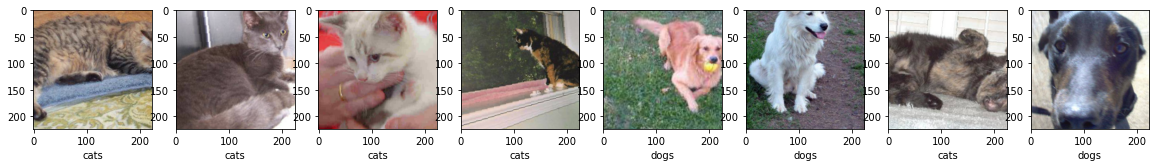

In [23]:
import numpy as np
test_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                         batch_size=batch_size, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

predictions = model(features[:8].to(device))
#print(predictions)
#predictions = int(predictions)
d = test_dataset.classes
#print(d)
#print(predictions)
predictions = torch.max(predictions,dim=1)[1]
predictions = predictions.cpu()
predictions = predictions.numpy()
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = features[i]
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[int(np.array(predictions[i].item()).round())])
    #print(int(np.array(predictions[i].item()).round()))

plt.show()